<a href="https://colab.research.google.com/github/arifpras/ExpectedDemand/blob/main/20240611_podem01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="markdown-google-sans">

  <h1> Predicting Demand in the Primary Market: Pycaret</h1>
</div>

<div class="markdown-google-sans">

## <strong> Data Preparation </strong>
</div>

## Libraries

In [1]:
%%capture

# !pip install -U scikit-learn==0.24.2
# !pip install -U imbalanced-learn

# %pip install openpyxl
# %pip install shap
# %pip install pycaret

!pip show pycaret || pip install pycaret

In [2]:
# Subsequent cells can use the installed library
import pycaret
pycaret.__version__

'3.3.2'

In [3]:
from pycaret.regression import *

import numpy as np
import pandas as pd
import openpyxl as xl
import matplotlib.pyplot as plt
import seaborn as sns

## Database

### Load

In [5]:
df_train00 = pd.read_excel('/content/drive/MyDrive/00database/db_monthfrac.xlsx', sheet_name='database')
df_train00['incoming_bid'] = df_train00['incoming_bid'].astype(float)
df_train00['issuance_date'] = pd.to_datetime(df_train00['issuance_date'], format='%Y-%m-%d')

df_train00.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1960 entries, 0 to 1959
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   issued_series     1960 non-null   object        
 1   issuance_date     1960 non-null   datetime64[ns]
 2   issuance_year     1960 non-null   int64         
 3   issuance_week     1960 non-null   int64         
 4   monthfrac         1960 non-null   int64         
 5   eid_weeks         1960 non-null   int64         
 6   srbi_issuance     1960 non-null   int64         
 7   vix_indicator     1960 non-null   int64         
 8   bi_covid          1960 non-null   int64         
 9   gso_issuance      1960 non-null   int64         
 10  investment_grade  1960 non-null   int64         
 11  incoming_bid      1960 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(9), object(1)
memory usage: 183.9+ KB


In [6]:
df_train00['issued_series'].value_counts()

issued_series
sun10    301
sun20    296
spn12    281
sun15    281
sun05    275
spn03    247
sun30    179
spn09     76
sun07     11
sun08     10
sun04      1
vr04       1
sun02      1
Name: count, dtype: int64

In [7]:
df_train00.describe()

,issuance_date,issuance_year,issuance_week,monthfrac,eid_weeks,srbi_issuance,vix_indicator,bi_covid,gso_issuance,investment_grade,incoming_bid
count,1960,1960.000000,1960.000000,1960.000000,1960.000000,1960.000000,1960.000000,1960.000000,1960.000000,1960.000000,1.960000e+03
mean,2017-10-23 11:02:41.632653312,2017.366327,24.247449,124.557653,0.081122,0.054592,0.079592,0.240816,0.021939,0.864796,6.295976e+06
min,2009-01-13 00:00:00,2009.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,2014-02-18 00:00:00,2014.000000,12.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.407100e+06
50%,2018-07-31 00:00:00,2018.000000,24.000000,119.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.434650e+06
75%,2021-06-25 12:00:00,2021.000000,36.000000,189.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,8.009500e+06
max,2024-05-28 00:00:00,2024.000000,51.000000,367.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.516780e+07
std,NaN,4.378061,14.042286,108.674048,0.273093,0.227240,0.270729,0.427688,0.146521,0.342029,5.914271e+06


<Axes: xlabel='incoming_bid', ylabel='issuance_week'>

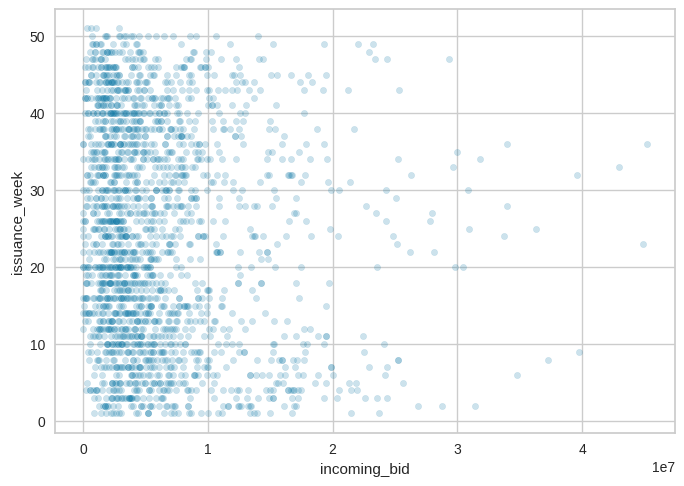

In [8]:
df_train00.plot(kind = 'scatter', x = 'incoming_bid', y = 'issuance_week', alpha = 0.2)

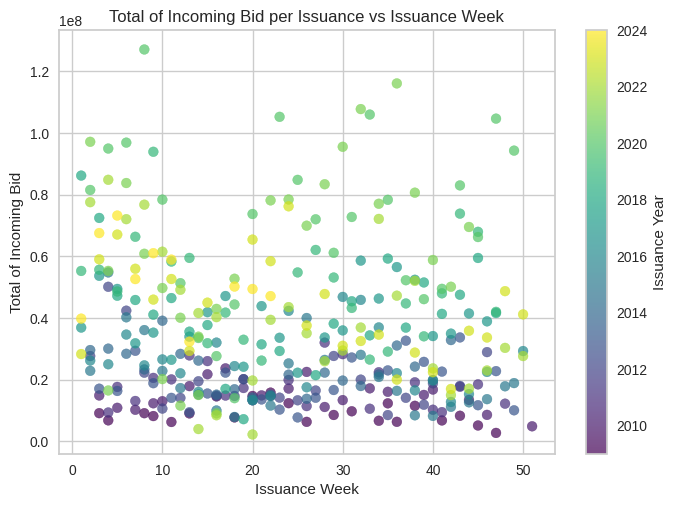

In [9]:
# import matplotlib.pyplot as plt

grouped_series01 = df_train00.groupby(['issuance_date']).agg({
    'incoming_bid': 'sum',
    'issuance_week': 'mean',
    'issuance_year': 'mean'
}).reset_index()

# Convert 'issuance_year' to integer
grouped_series01['issuance_year'] = grouped_series01['issuance_year'].astype(int)


# Scatter plot
# plt.figure(figsize=(10, 6))
plt.scatter(grouped_series01['issuance_week'], grouped_series01['incoming_bid'], s=50, c=grouped_series01['issuance_year'], alpha=0.7, cmap='viridis')
plt.title('Total of Incoming Bid per Issuance vs Issuance Week')
plt.xlabel('Issuance Week')
plt.ylabel('Total of Incoming Bid')
plt.colorbar(label='Issuance Year')
plt.grid(True)
plt.show()

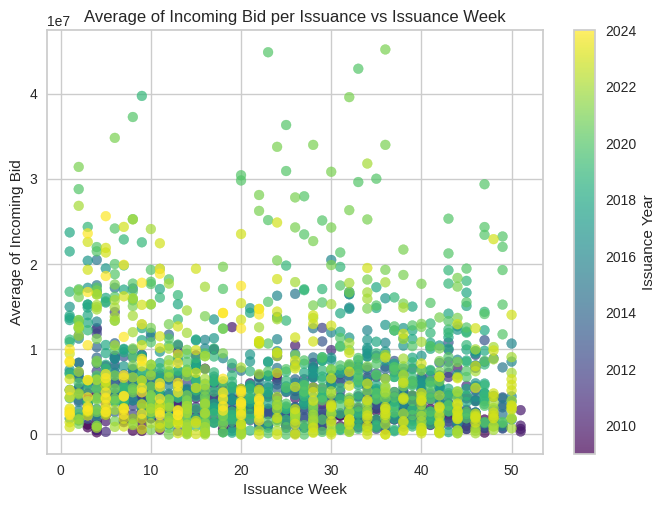

In [10]:
# import matplotlib.pyplot as plt

grouped_series02 = df_train00.groupby(['issuance_date', 'issued_series']).agg({
    'incoming_bid': 'mean', #average
    'issuance_week': 'mean',
    'issuance_year': 'mean'
}).reset_index()

# Convert 'issuance_year' to integer
grouped_series02['issuance_year'] = grouped_series02['issuance_year'].astype(int)


# Scatter plot
# plt.figure(figsize=(10, 6))
plt.scatter(grouped_series02['issuance_week'], grouped_series02['incoming_bid'], s=50, c=grouped_series02['issuance_year'], alpha=0.7, cmap='viridis')
plt.title('Average of Incoming Bid per Issuance vs Issuance Week')
plt.xlabel('Issuance Week')
plt.ylabel('Average of Incoming Bid')
plt.colorbar(label='Issuance Year')
plt.grid(True)
plt.show()

In [11]:
# sns.catplot(x='issued_series', y='incoming_bid', data=grouped_series02,
#                 kind='boxen', col='issuance_year', col_wrap=2)

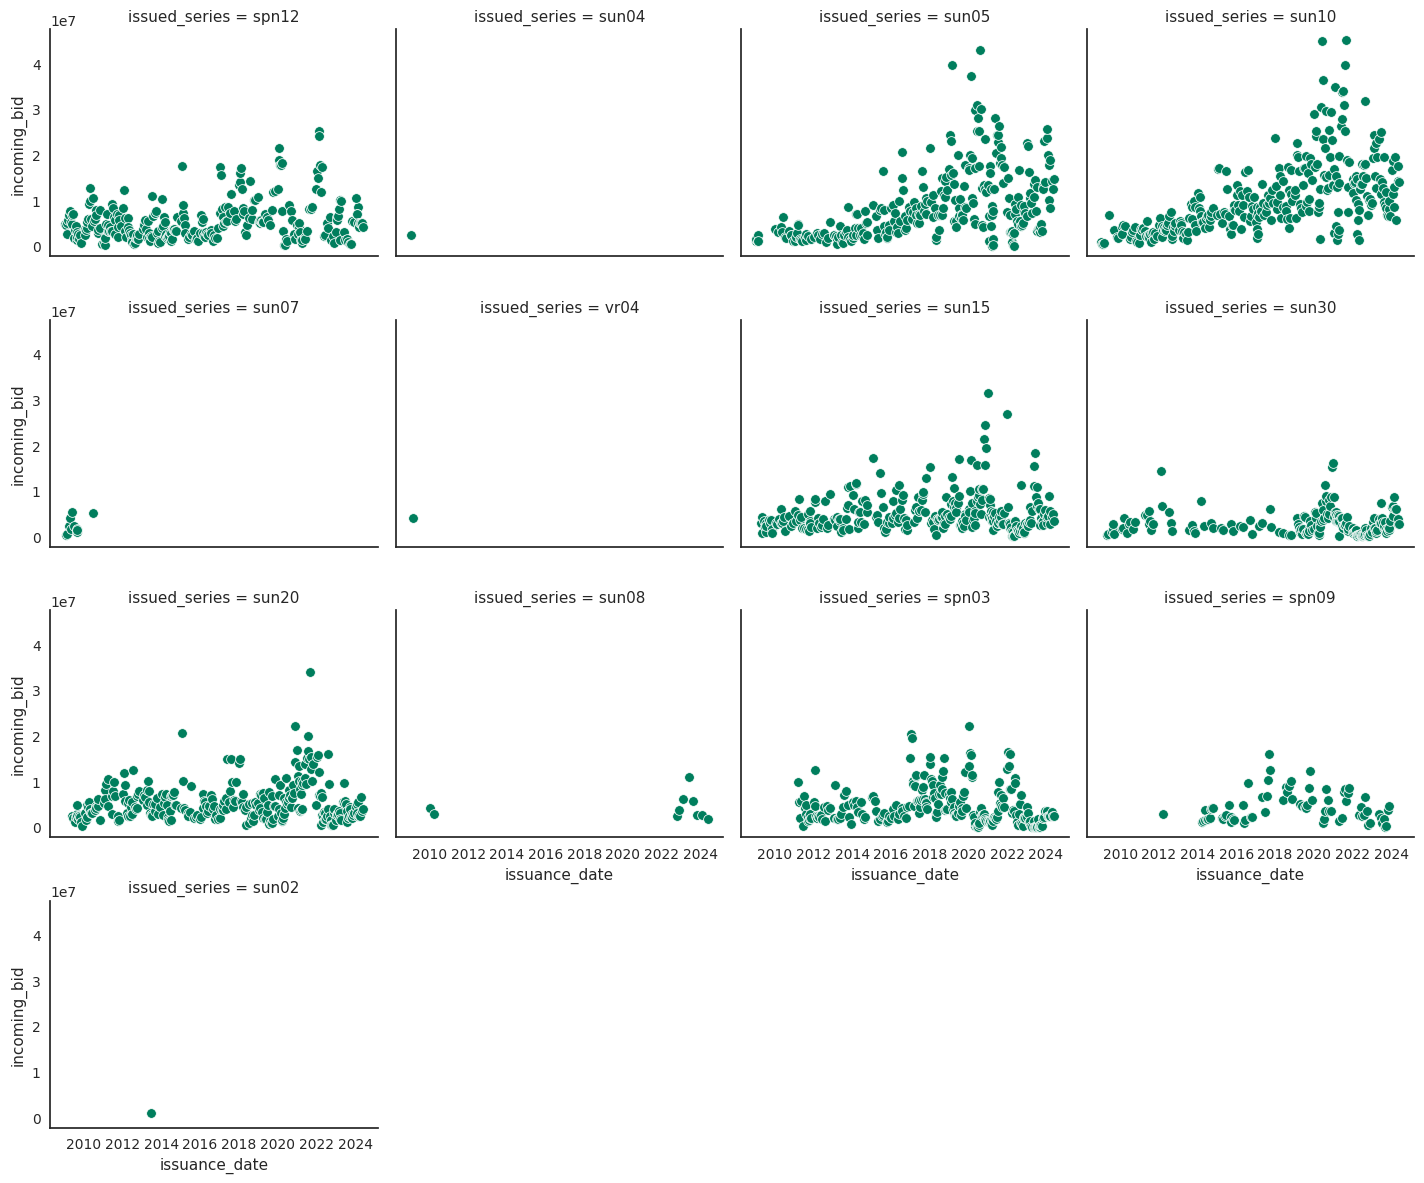

In [12]:
# import seaborn as sns
# import matplotlib.pyplot as plt

sns.set_style("white")

# Create a FacetGrid and use map to create subplots based on 'FacetVar'
ch01 = sns.FacetGrid(df_train00, col='issued_series', col_wrap=4, height=3, aspect=1.2)
ch01.map(sns.scatterplot, 'issuance_date', 'incoming_bid', color='#007e5d')

# Show the plot
# plt.show()


In [13]:
# corr_matrix = df_train00.corr()
# corr_matrix['incoming_bid'].sort_values(ascending=False)

In [14]:
df_train01 = df_train00[~df_train00['issued_series'].isin(['sun04', 'sun02', 'vr04', 'spn09', 'sun07'])]

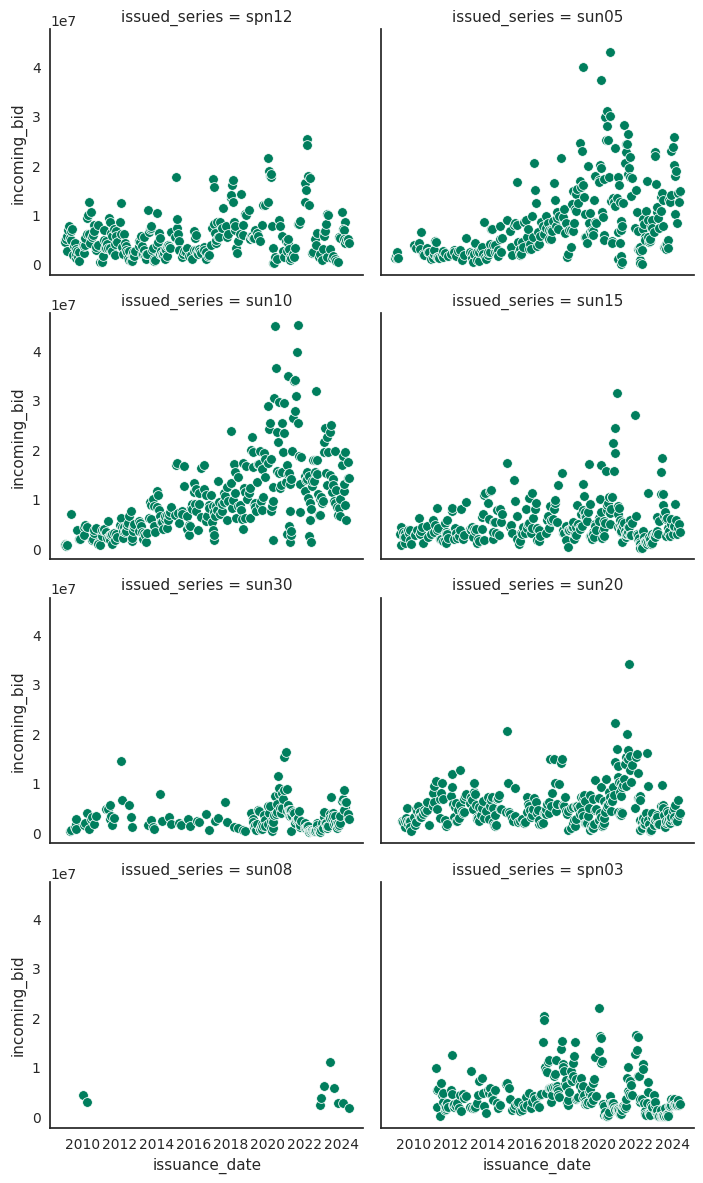

In [15]:
# import seaborn as sns
# import matplotlib.pyplot as plt

sns.set_style("white")

# Create a FacetGrid and use map to create subplots based on 'FacetVar'
ch02 = sns.FacetGrid(df_train01, col='issued_series', col_wrap=2, height=3, aspect=1.2)
ch02.map(sns.scatterplot, 'issuance_date', 'incoming_bid', color='#007e5d')

# Show the plot
# plt.show()


In [16]:
# Get the order of categories
issd_series = df_train01['issued_series'].unique()

# Sort the order
issd_series.sort()

# Create a boxplot with sorted order
# sns.boxplot(x='issued_series', y='incoming_bid', data=df_train01,
#             order=issd_series, hue='issuance_year')

# sns.boxplot(x='issued_series', y='incoming_bid', data=df_train01,
#             order=issd_series)
# plt.show()

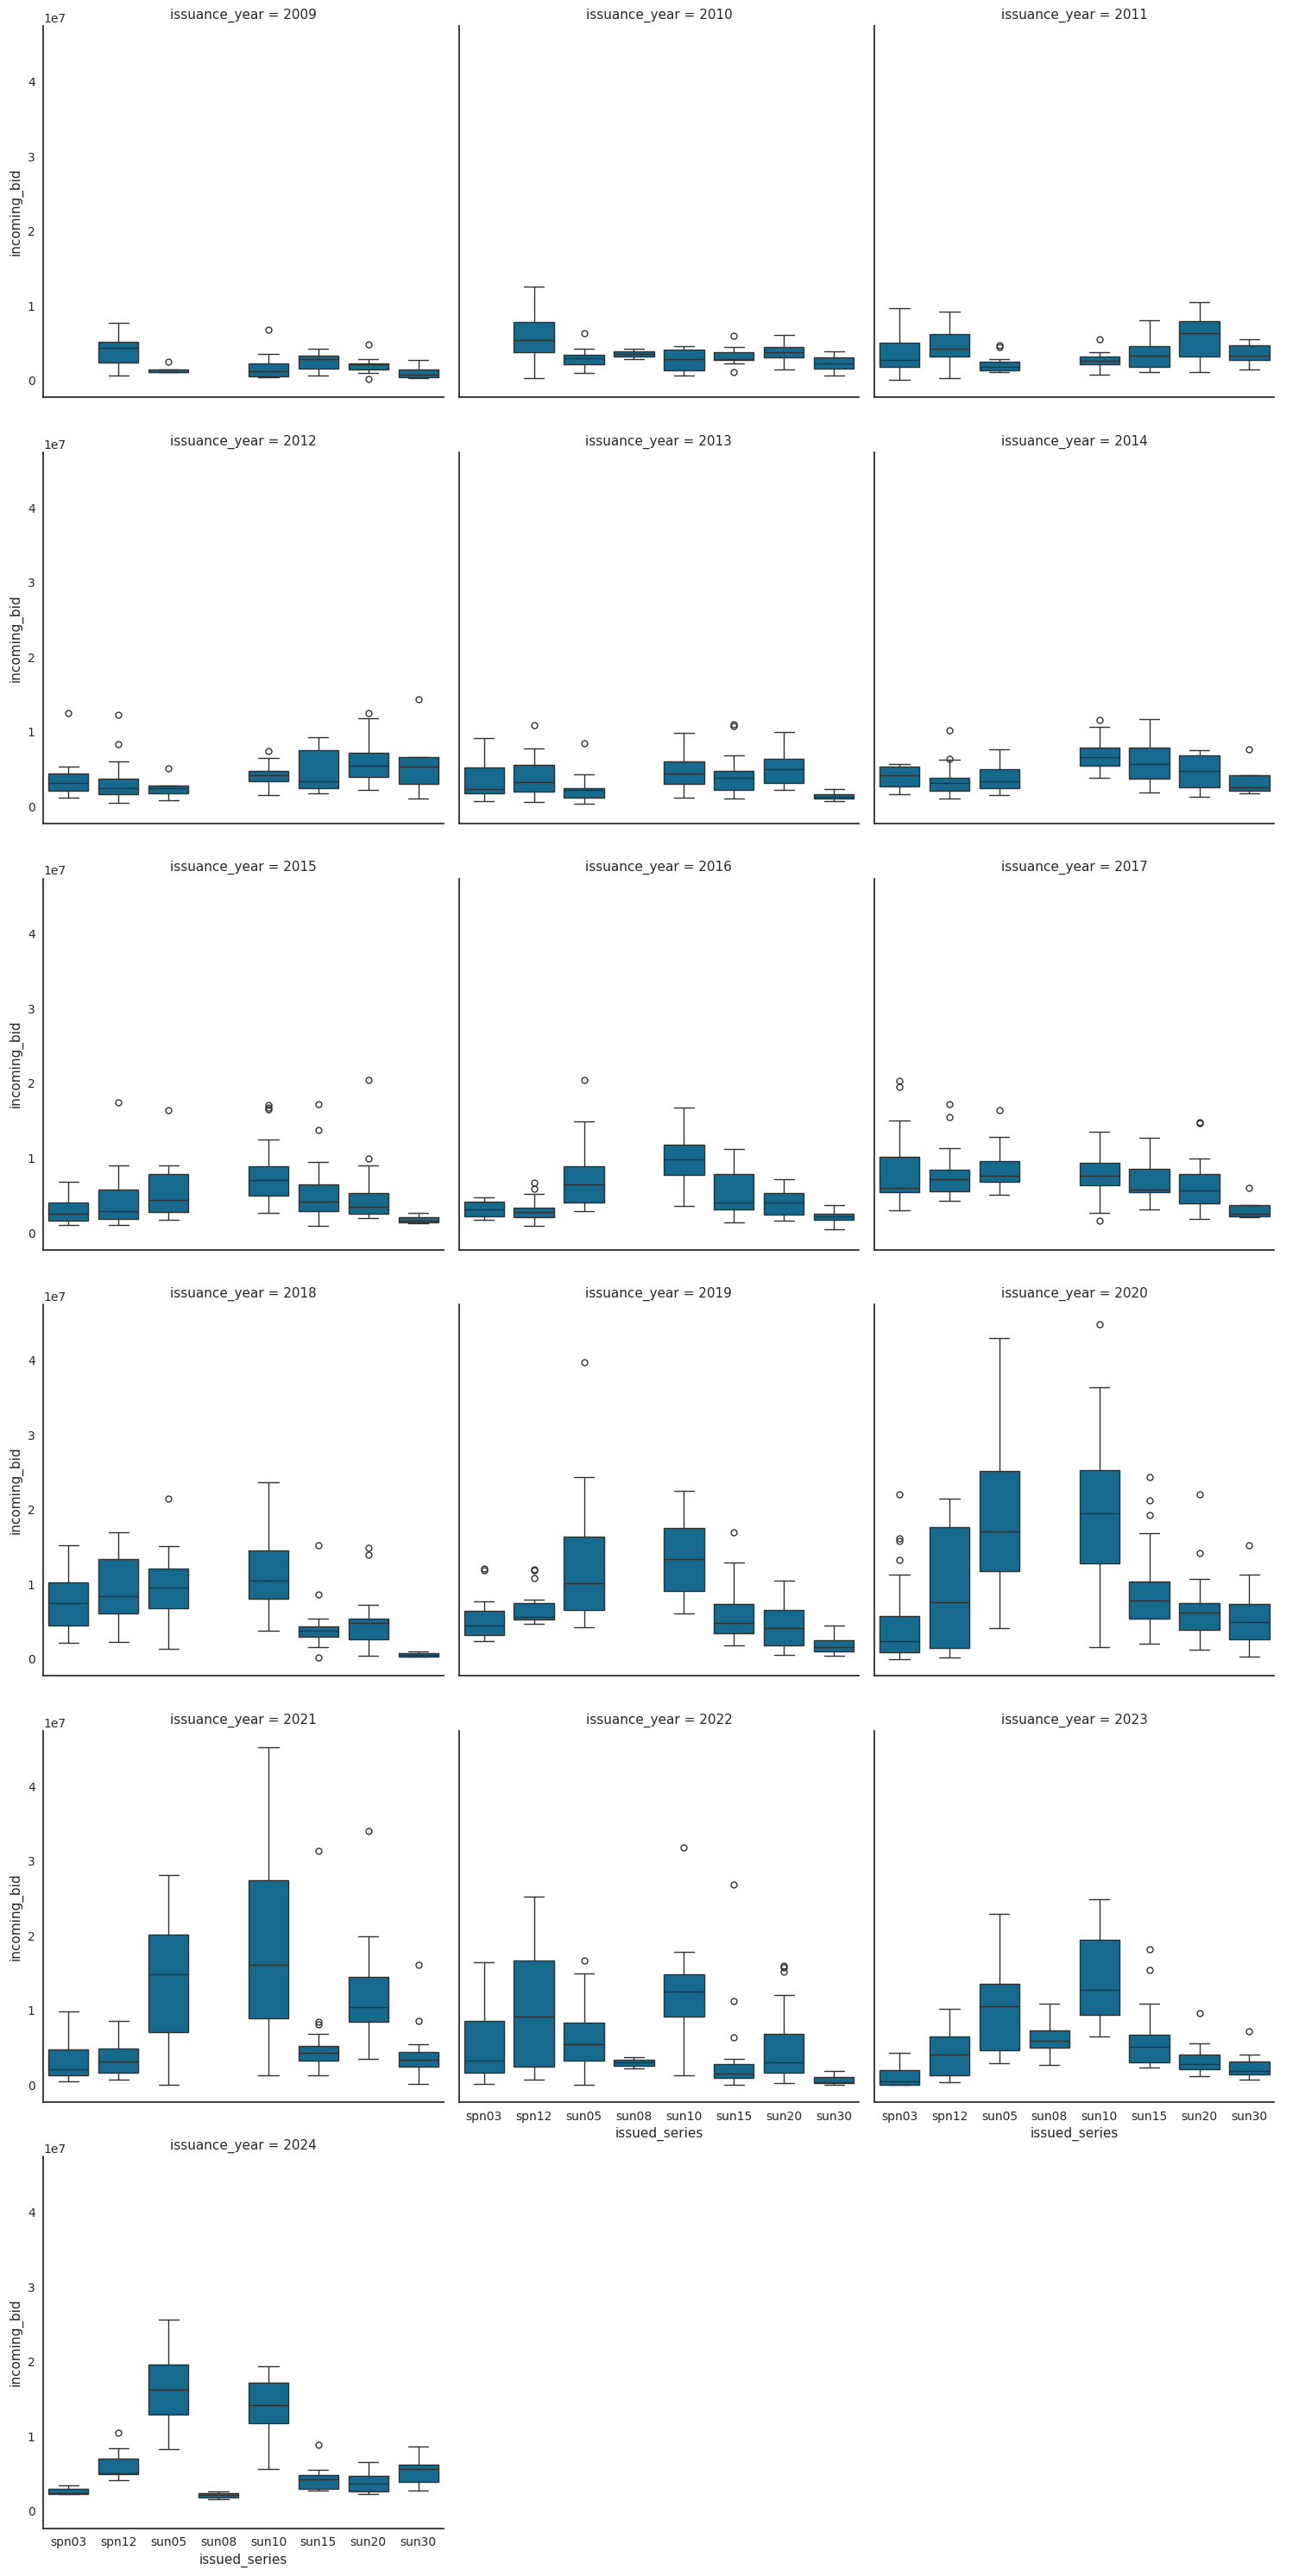

In [17]:
sns.catplot(x='issued_series', y='incoming_bid', data=df_train01,
                order=issd_series, kind='box', col='issuance_year', col_wrap=3)

### Split: Biased

In [18]:
# df_train02 = df_train01.sample(frac=0.9, random_state=786)
# df_unseen01 = df_train01.drop(df_train02.index)

# df_train02.reset_index(drop=True, inplace=True)
# df_unseen01.reset_index(drop=True, inplace=True)

# print('Data for Modeling: ' + str(df_train02.shape))
# print('Unseen Data For Predictions: ' + str(df_unseen01.shape))

In [19]:
# print("Train: \n{} \n\nTest: \n{}".format(df_train02['issued_series'].value_counts(), df_unseen01['issued_series'].value_counts()))

### Split: Stratified

In [20]:
from sklearn.model_selection import StratifiedShuffleSplit

# Assuming df is your DataFrame and 'target_column' is the target variable
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_index, test_index in split.split(df_train01, df_train01['issued_series']):
    # Explicitly reset the index
    df_train02 = df_train01.iloc[train_index]
    df_unseen01 = df_train01.iloc[test_index]

# Explicitly reset the index for df_train02 and df_test01
# df_train02 = df_train02.reset_index(drop=True)
# df_unseen01 = df_unseen01.reset_index(drop=True)

# Display the shapes of the resulting sets (optional)
print("Train set shape:", df_train02.shape)
print("Test set shape:", df_unseen01.shape)

Train set shape: (1683, 12)
Test set shape: (187, 12)


In [21]:
print("Train: \n{} \n\nTest: \n{}".format(df_train02['issued_series'].value_counts(), df_unseen01['issued_series'].value_counts()))

Train: 
issued_series
sun10    271
sun20    266
spn12    253
sun15    253
sun05    248
spn03    222
sun30    161
sun08      9
Name: count, dtype: int64 

Test: 
issued_series
sun20    30
sun10    30
spn12    28
sun15    28
sun05    27
spn03    25
sun30    18
sun08     1
Name: count, dtype: int64


In [22]:
# Identifying duplicates
duplicates = df_train02[df_train02.index.duplicated()]
print("Rows with duplicate indices:")
print(duplicates)


Rows with duplicate indices:
Empty DataFrame
Columns: [issued_series, issuance_date, issuance_year, issuance_week, monthfrac, eid_weeks, srbi_issuance, vix_indicator, bi_covid, gso_issuance, investment_grade, incoming_bid]
Index: []


In [23]:
# Identifying duplicates
duplicates = df_unseen01[df_unseen01.index.duplicated()]
print("Rows with duplicate indices:")
print(duplicates)

Rows with duplicate indices:
Empty DataFrame
Columns: [issued_series, issuance_date, issuance_year, issuance_week, monthfrac, eid_weeks, srbi_issuance, vix_indicator, bi_covid, gso_issuance, investment_grade, incoming_bid]
Index: []


# Methods

## Setup

In [24]:
session01 = setup(data=df_train02, target='incoming_bid', session_id=123,
                  test_data=df_unseen01,
                  categorical_features=['issued_series'],
                  ignore_features = ['issuance_date'])

,Description,Value
0,Session id,123
1,Target,incoming_bid
2,Target type,Regression
3,Original data shape,"(1870, 12)"
4,Transformed data shape,"(1870, 18)"
5,Transformed train set shape,"(1683, 18)"
6,Transformed test set shape,"(187, 18)"
7,Ignore features,1
8,Numeric features,9
9,Categorical features,1


## Compare Models

In [25]:
best01 = compare_models(sort = 'rmse')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,2367378.6308,12744930813669.6348,3533069.3617,0.6514,1.1366,0.8256,0.8020
xgboost,Extreme Gradient Boosting,2404185.7875,12880804472422.4004,3562704.9000,0.6449,1.2021,0.9367,0.1460
lightgbm,Light Gradient Boosting Machine,2430451.9750,13084900446329.3164,3588882.0357,0.6388,1.2228,0.9250,0.9220
rf,Random Forest Regressor,2432502.4770,13313229404087.7422,3602776.8196,0.6379,1.2128,0.9899,0.5200
gbr,Gradient Boosting Regressor,2886540.6846,17435296090740.3398,4142855.7857,0.5215,1.3063,1.2555,0.1990
knn,K Neighbors Regressor,3163698.7500,20971597280051.1992,4547964.2000,0.4198,1.3610,1.6987,0.0690
dt,Decision Tree Regressor,3050757.8651,21820701048765.8203,4614347.0048,0.3942,1.2384,0.8299,0.0780
lasso,Lasso Regression,3667385.0990,26257658851367.5898,5101705.7732,0.2758,1.4977,2.3378,0.0800
llar,Lasso Least Angle Regression,3667783.4830,26258553979976.3555,5101821.8487,0.2758,1.4985,2.3378,0.1320
lr,Linear Regression,3667787.7331,26258550025026.5742,5101821.9410,0.2758,1.4985,2.3378,0.6430


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

## Features

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2465790.8920,13047982702072.5449,3612199.1504,0.6127,1.3329,0.6558
1,2541494.3395,15524505501546.6680,3940114.9097,0.5368,1.2451,0.6522
2,2329879.1920,10618561382870.3789,3258613.4141,0.7416,1.6951,0.6730
3,2333634.5386,13998307771052.7285,3741431.2463,0.6149,1.6466,0.8053
4,2425532.1425,9917405021056.7207,3149191.1693,0.6971,0.8908,1.3734
5,2229131.7229,9689726208688.0918,3112832.5057,0.7334,1.6725,1.7605
6,2479321.6934,12805289991126.0332,3578447.9864,0.5741,1.2339,1.1880
7,2216437.6134,10311917413811.7773,3211217.4348,0.6787,0.5677,0.6170
8,2954087.2333,22067682158148.5664,4697625.1615,0.5996,0.6805,0.8738


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

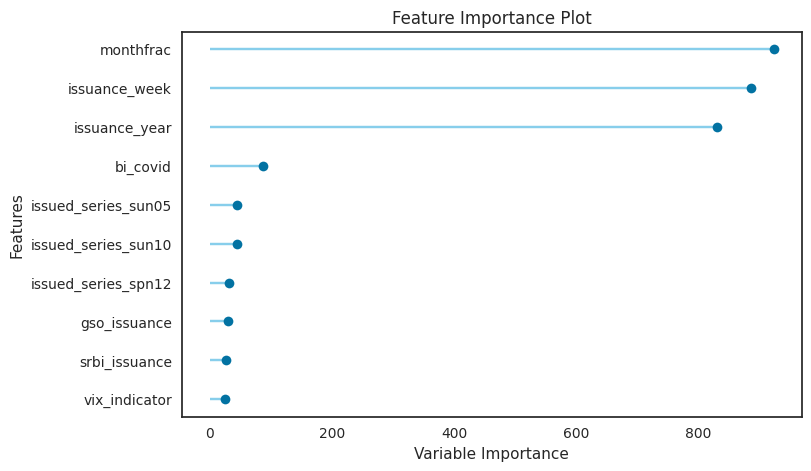

In [28]:
plot_model(create_model('lightgbm'), plot='feature')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2475723.2500,12187883012096.0000,3491114.7500,0.6382,1.2381,0.5913
1,2582927.2500,14043572076544.0000,3747475.5000,0.5810,1.2154,0.6394
2,2274250.2500,11134441619456.0000,3336831.0000,0.7290,1.6916,0.6155
3,2403919.7500,15016878145536.0000,3875161.7500,0.5869,1.7191,0.8234
4,2321366.0000,10403631333376.0000,3225466.0000,0.6823,0.7757,1.1787
5,2073090.6250,9021649059840.0000,3003606.0000,0.7518,1.6235,1.7550
6,2250870.0000,10728797896704.0000,3275484.5000,0.6431,1.1871,1.6530
7,2367426.0000,11369590030336.0000,3371882.2500,0.6458,0.6187,0.7118
8,2865826.2500,21415644364800.0000,4627704.0000,0.6114,0.6577,0.7672


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

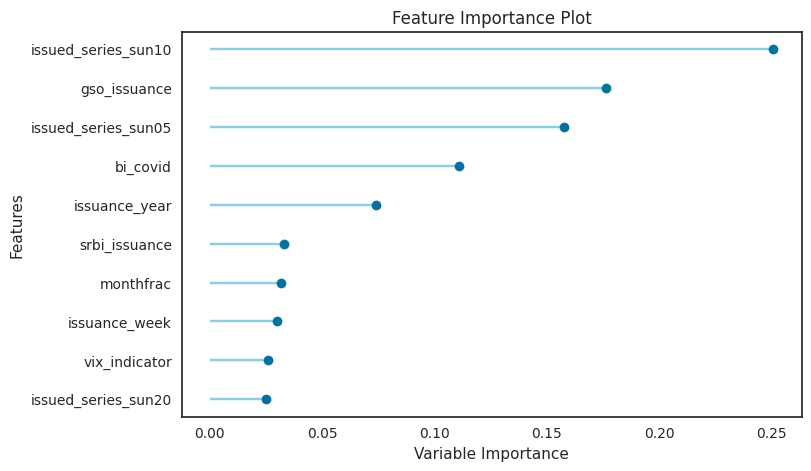

In [29]:
plot_model(create_model('xgboost'), plot='feature')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2008433.1686,8552702398354.8701,2924500.3673,0.7461,1.1148,0.4799
1,2421690.0947,13528238054132.9590,3678075.3193,0.5964,1.3257,0.5724
2,2365334.4497,11872539192749.9297,3445655.1181,0.7111,1.5133,0.6027
3,2340348.0179,13176804383573.8633,3629986.8297,0.6375,1.4737,0.6531
4,2488783.8214,11363007439404.9727,3370906.0265,0.6530,0.7392,1.1422
5,2057584.4226,9200184193626.5293,3033180.5409,0.7469,1.5914,1.2112
6,2418245.5179,12391374476489.6602,3520138.4172,0.5878,1.1303,1.6714
7,2381288.4940,13128562139867.0293,3623335.7752,0.5910,0.6909,0.5814
8,3047589.7321,23877346333615.6250,4886445.1633,0.5668,0.6926,0.8078


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

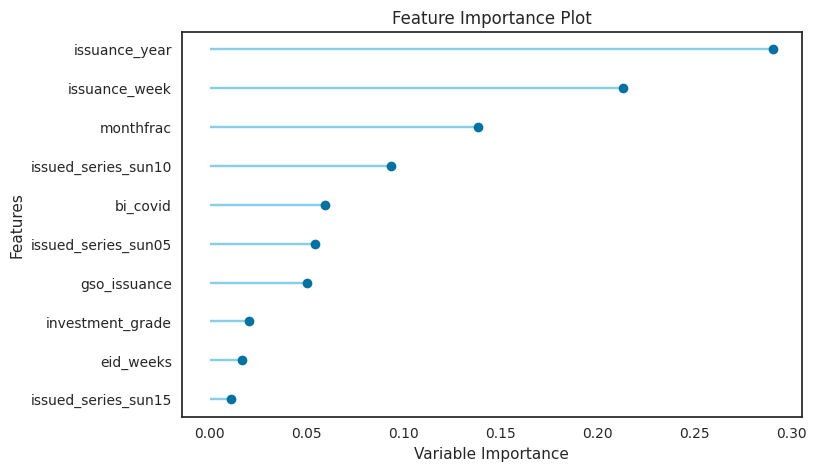

In [30]:
plot_model(create_model('et'), plot='feature')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2196505.4334,10544102385559.1250,3247168.3642,0.6870,1.2066,0.5632
1,2641646.4995,15758083234840.4375,3969645.2278,0.5299,1.2796,0.6866
2,2421257.1551,11484985195047.2285,3388950.4563,0.7205,1.6414,0.6752
3,2373246.2278,14736215632283.0938,3838777.8826,0.5946,1.6860,0.7805
4,2533927.2640,11058552243370.1836,3325440.1578,0.6623,0.7996,1.3432
5,2170428.1369,8964968326279.3809,2994155.6951,0.7533,1.7229,2.2752
6,2332853.4183,11352100481017.4668,3369287.8299,0.6224,1.2579,1.5095
7,2235614.3027,10704286506748.9727,3271740.5928,0.6665,0.6001,0.6205
8,3101092.6310,26360140521560.0234,5134212.7460,0.5217,0.6881,0.8316


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

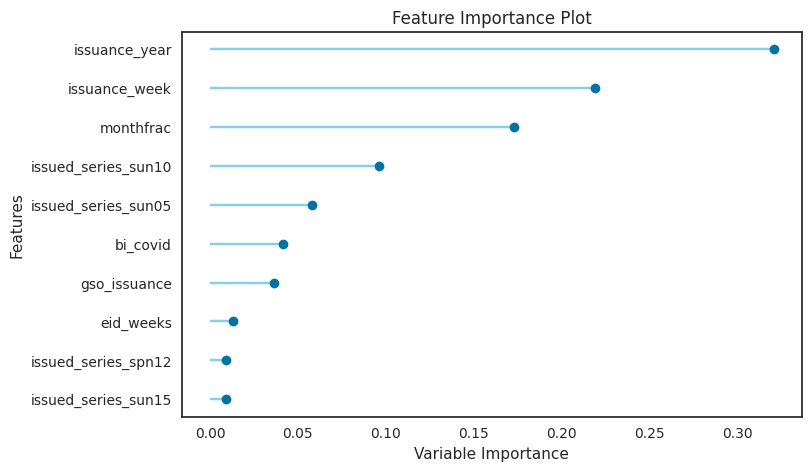

In [31]:
plot_model(create_model('rf'), plot='feature')

# Algorithms

## Light Gradient Boosting Machine

### Raw -- 63.88%

In [32]:
# train a xgb model with default params
lightgbm_raw = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2465790.8920,13047982702072.5449,3612199.1504,0.6127,1.3329,0.6558
1,2541494.3395,15524505501546.6680,3940114.9097,0.5368,1.2451,0.6522
2,2329879.1920,10618561382870.3789,3258613.4141,0.7416,1.6951,0.6730
3,2333634.5386,13998307771052.7285,3741431.2463,0.6149,1.6466,0.8053
4,2425532.1425,9917405021056.7207,3149191.1693,0.6971,0.8908,1.3734
5,2229131.7229,9689726208688.0918,3112832.5057,0.7334,1.6725,1.7605
6,2479321.6934,12805289991126.0332,3578447.9864,0.5741,1.2339,1.1880
7,2216437.6134,10311917413811.7773,3211217.4348,0.6787,0.5677,0.6170
8,2954087.2333,22067682158148.5664,4697625.1615,0.5996,0.6805,0.8738


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 59.18%

In [33]:
# tune hyperparameters of lightgbm
lightgbm_tuned = tune_model(lightgbm_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2807183.7415,14929274896298.1445,3863841.9865,0.5569,1.2803,0.8811
1,2891991.7545,18221705769287.5469,4268688.9989,0.4564,1.3893,0.7433
2,2703333.8642,13030126489672.1270,3609726.6503,0.6829,1.8232,0.8801
3,2654181.5486,16138067146976.9414,4017221.3216,0.5560,1.6082,0.8940
4,2438422.1035,10188772259998.3711,3191985.6297,0.6888,0.8110,1.4009
5,2233036.5017,10481985059834.0234,3237589.3902,0.7116,1.6843,1.2292
6,2681874.4992,14320908786407.3027,3784297.6609,0.5236,1.3087,2.7024
7,2618213.2844,11477323984228.6250,3387819.9457,0.6424,0.7848,1.0136
8,3276165.5317,28319984436629.0586,5321652.4160,0.4862,0.7340,0.8226


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Modifying -- 65.57%

In [34]:

# Define a more comprehensive tuning grid for LightGBM
lightgbm_grid = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9, 11],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.01, 0.001],
    'reg_lambda': [1, 1.5, 2, 3, 4],
    'num_leaves': [15, 31, 63, 127],
    'min_split_gain': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample_freq': [0, 1, 2],
}

# Tune LightGBM model with custom grid and optimize for R2
lightgbm_modified = tune_model(lightgbm_raw, custom_grid=lightgbm_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2537454.5378,13337940632374.5352,3652114.5426,0.6041,1.2775,0.6926
1,2567873.5794,14542139997382.8633,3813415.7913,0.5661,1.2740,0.6374
2,2343884.9569,10440146911694.5566,3231121.6182,0.7459,1.7444,0.6827
3,2380838.2332,13800702489058.5176,3714929.6748,0.6203,1.6843,0.7651
4,2313424.0083,9650108134189.7500,3106462.3182,0.7053,0.8314,1.4177
5,2075420.4609,8707671069662.1855,2950876.3223,0.7604,1.7523,1.2340
6,2324740.8153,11171338161517.3613,3342355.1818,0.6284,1.2694,0.8148
7,2349792.7829,10567907684440.9414,3250831.8450,0.6707,0.6751,0.8297
8,2927324.4440,20867371186817.8828,4568081.7842,0.6214,0.6989,0.8136


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


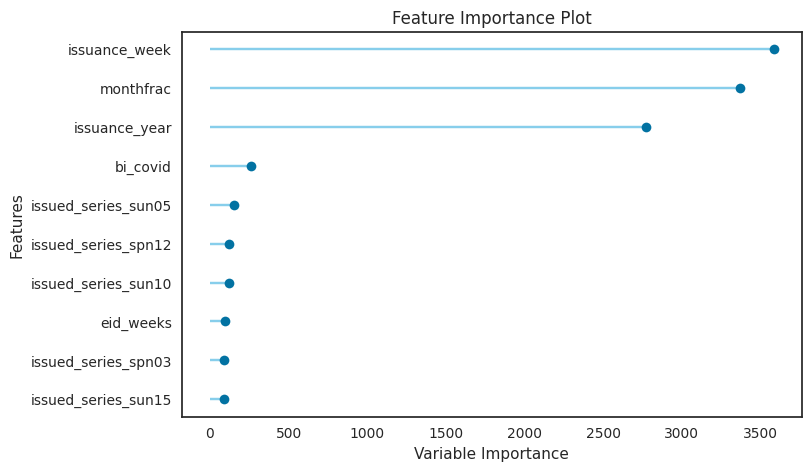

In [35]:
plot_model(lightgbm_modified, plot = 'feature')

### Bagging -- 63.40%

In [36]:
# ensemble with bagging
lightgbm_bagged = ensemble_model(lightgbm_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2523057.3767,13581413451353.0527,3685296.9285,0.5969,1.3297,0.6927
1,2622758.5032,14953253852510.4102,3866943.7354,0.5539,1.2532,0.6961
2,2350455.1836,10996318604723.5312,3316069.7527,0.7324,1.7333,0.6304
3,2381623.6544,14013704484525.9434,3743488.2776,0.6145,1.6075,0.8523
4,2443369.8439,9879480086516.7656,3143164.0248,0.6983,0.7881,1.4030
5,2323240.2123,10736971387886.0625,3276731.8151,0.7046,1.6527,1.9856
6,2509249.6729,12648391739839.9258,3556457.7517,0.5793,1.1972,0.6141
7,2176285.5482,9865681559407.2676,3140968.2519,0.6926,0.6026,0.6431
8,3079131.3069,23318615676129.2188,4828935.2528,0.5769,0.7183,0.8980


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 63.97%

In [37]:
# ensemble with boosting
lightgbm_boosted = ensemble_model(lightgbm_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2525172.4213,13079365882666.2246,3616540.5960,0.6118,1.3133,0.6789
1,2822698.8524,15592061439666.9121,3948678.4422,0.5348,1.2929,0.7661
2,2503156.9126,11102355927216.2637,3332019.7969,0.7298,1.7471,0.7191
3,2462678.1519,14182903128641.1523,3766019.5338,0.6098,1.6481,0.9007
4,2458684.0962,10290811111785.6797,3207929.4119,0.6857,0.8534,1.4958
5,2104577.1496,9101071821476.4648,3016798.2732,0.7496,1.6999,1.6352
6,2455545.6015,12132870956752.6758,3483227.0895,0.5964,1.1510,1.0319
7,2244024.9396,9916413047516.6191,3149033.6688,0.6910,0.6540,0.8471
8,3093368.6410,23564472742229.0078,4854325.1583,0.5724,0.7435,0.8850


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

## Extreme Gradient Boosting

### Raw -- 64.49%

In [38]:
# train a xgb model with default params
xgb_raw = create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2475723.2500,12187883012096.0000,3491114.7500,0.6382,1.2381,0.5913
1,2582927.2500,14043572076544.0000,3747475.5000,0.5810,1.2154,0.6394
2,2274250.2500,11134441619456.0000,3336831.0000,0.7290,1.6916,0.6155
3,2403919.7500,15016878145536.0000,3875161.7500,0.5869,1.7191,0.8234
4,2321366.0000,10403631333376.0000,3225466.0000,0.6823,0.7757,1.1787
5,2073090.6250,9021649059840.0000,3003606.0000,0.7518,1.6235,1.7550
6,2250870.0000,10728797896704.0000,3275484.5000,0.6431,1.1871,1.6530
7,2367426.0000,11369590030336.0000,3371882.2500,0.6458,0.6187,0.7118
8,2865826.2500,21415644364800.0000,4627704.0000,0.6114,0.6577,0.7672


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 66.57%

In [39]:
# tune hyperparameters of xgb
xgb_tuned = tune_model(xgb_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2490674.0000,12843606867968.0000,3583797.7500,0.6188,1.2856,0.6618
1,2459658.5000,12933093392384.0000,3596261.0000,0.6141,1.1784,0.6070
2,2277841.2500,10659988242432.0000,3264963.7500,0.7406,1.6729,0.6232
3,2397215.0000,12924648161280.0000,3595086.7500,0.6444,1.7259,0.7971
4,2251793.2500,8979204800512.0000,2996532.2500,0.7258,0.7653,1.2386
5,2082974.8750,8636455190528.0000,2938784.7500,0.7624,1.6364,1.0213
6,2321860.2500,9920899448832.0000,3149746.0000,0.6700,1.2357,0.5879
7,2355737.5000,11059909885952.0000,3325644.2500,0.6554,0.6716,0.6538
8,2860855.2500,19691816878080.0000,4437546.5000,0.6427,0.6443,0.7058


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


### Modifying -- 65.95%

In [40]:
# define a more comprehensive tuning grid for XGBoost
xgb_grid = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9, 11],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.1, 0.01, 0.001],
    'reg_lambda': [1, 1.5, 2, 3, 4]
}

# tune model with custom grid and optimize for R2
xgb_modified = tune_model(xgb_raw, custom_grid=xgb_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2428187.7500,12756416724992.0000,3571612.5000,0.6214,1.1065,0.6292
1,2562449.0000,13945882542080.0000,3734418.7500,0.5839,1.2775,0.6685
2,2313481.5000,10893206224896.0000,3300485.7500,0.7349,1.6904,0.5704
3,2349791.7500,13259970183168.0000,3641424.2500,0.6352,1.6710,0.8286
4,2258238.7500,9268027719680.0000,3044343.5000,0.7170,0.7515,1.1721
5,2211858.5000,9617262247936.0000,3101171.0000,0.7354,1.6684,1.3499
6,2355484.5000,11261282615296.0000,3355783.5000,0.6254,1.2650,1.0466
7,2320874.7500,10516773732352.0000,3242957.5000,0.6723,0.8456,0.8163
8,2878467.0000,21066172858368.0000,4589790.0000,0.6178,0.6680,0.7770


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


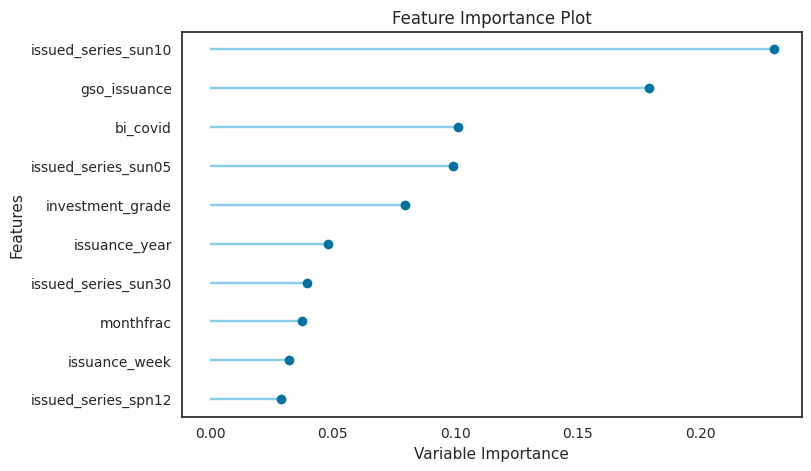

In [41]:
plot_model(xgb_modified, plot = 'feature')

### Bagging -- 66.04%

In [42]:
# ensemble with bagging
xgb_bagged = ensemble_model(xgb_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2407866.2500,11677444603904.0000,3417227.5000,0.6534,1.2265,0.6261
1,2543853.5000,13435642314752.0000,3665466.2500,0.5992,1.2408,0.6369
2,2251632.0000,9923922493440.0000,3150225.7500,0.7585,1.6374,0.5624
3,2197009.7500,13141516746752.0000,3625123.0000,0.6385,1.6057,0.7674
4,2313082.2500,9043002261504.0000,3007158.5000,0.7238,0.7451,1.0957
5,2188909.2500,9754388725760.0000,3123201.7500,0.7316,1.6327,2.1466
6,2410124.2500,11394627928064.0000,3375593.0000,0.6210,1.1654,1.3691
7,2203437.0000,9802893754368.0000,3130957.2500,0.6946,0.5900,0.6399
8,2876840.5000,21051224358912.0000,4588161.5000,0.6180,0.6726,0.8290


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 65.35%

In [43]:
# ensemble with boosting
xgb_boosted = ensemble_model(xgb_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2438404.5000,12186645692416.0000,3490937.7500,0.6383,1.3547,0.6994
1,2702451.0000,14633682337792.0000,3825399.7500,0.5634,1.2390,0.6945
2,2319026.2500,11062983262208.0000,3326106.2500,0.7308,1.6139,0.6120
3,2299780.7500,13449750904832.0000,3667390.2500,0.6300,1.6794,0.7615
4,2266844.2500,8805133844480.0000,2967344.5000,0.7311,0.7193,1.0702
5,2160492.7500,9412665147392.0000,3068006.7500,0.7410,1.5837,1.1431
6,2288604.0000,11212815335424.0000,3348554.2500,0.6270,1.1731,1.1726
7,2179784.7500,10227882655744.0000,3198106.0000,0.6813,0.6108,0.6225
8,2918066.0000,21066550345728.0000,4589831.0000,0.6178,0.6656,0.7968


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

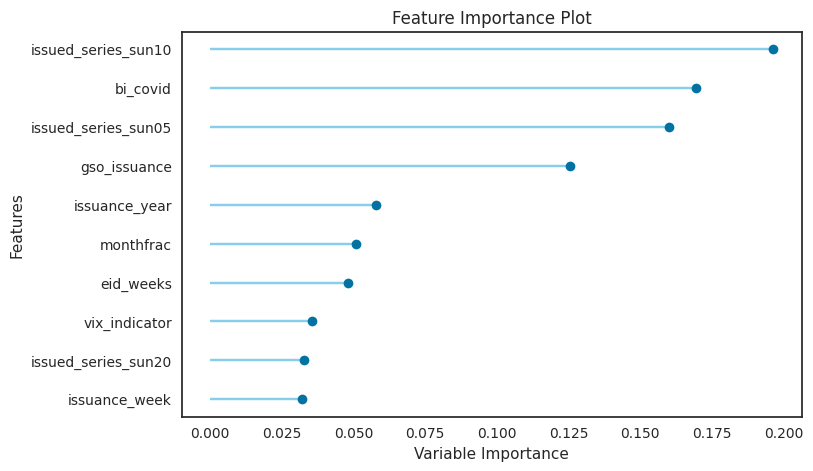

In [44]:
plot_model(xgb_boosted, plot = 'feature')

## Extra Trees Regressor

### Raw -- 65.14%

In [45]:
# train a et model with default params
et_raw = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2008433.1686,8552702398354.8701,2924500.3673,0.7461,1.1148,0.4799
1,2421690.0947,13528238054132.9590,3678075.3193,0.5964,1.3257,0.5724
2,2365334.4497,11872539192749.9297,3445655.1181,0.7111,1.5133,0.6027
3,2340348.0179,13176804383573.8633,3629986.8297,0.6375,1.4737,0.6531
4,2488783.8214,11363007439404.9727,3370906.0265,0.6530,0.7392,1.1422
5,2057584.4226,9200184193626.5293,3033180.5409,0.7469,1.5914,1.2112
6,2418245.5179,12391374476489.6602,3520138.4172,0.5878,1.1303,1.6714
7,2381288.4940,13128562139867.0293,3623335.7752,0.5910,0.6909,0.5814
8,3047589.7321,23877346333615.6250,4886445.1633,0.5668,0.6926,0.8078


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 55.03%

In [46]:
# tune hyperparameters of et
et_tuned = tune_model(et_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2684744.8695,15394765708804.6660,3923616.4069,0.5430,1.3353,0.8413
1,2912878.8465,19046013766246.6250,4364173.8928,0.4318,1.3379,0.8006
2,2749139.8421,14328236377453.8145,3785265.6944,0.6513,1.8010,0.9761
3,2448061.0411,13419651059855.7324,3663284.1904,0.6308,1.7788,1.0171
4,2857052.1599,14757530822213.6836,3841553.1784,0.5493,0.8467,1.4957
5,2559435.6382,13625540041686.1758,3691278.9168,0.6251,1.8221,2.4963
6,2706939.7161,15479226697172.4570,3934364.8404,0.4851,1.3932,3.5364
7,2621474.7038,12618691856798.7129,3552279.8112,0.6068,0.7482,0.9999
8,3583985.0532,30633694519110.4336,5534771.4062,0.4442,0.7907,1.1400


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Modifying -- 60.72%

In [47]:
# define a more comprehensive tuning grid for Random Forest Regressor
et_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 4, 8, 12],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt', None],
    'bootstrap': [True, False]
}

# Tune model with the optimized grid and optimize for Mean Squared Error (mse)
et_modified = tune_model(et_raw, custom_grid=et_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2316015.9416,12599789686149.1973,3549618.2451,0.6260,1.2666,0.6674
1,2630178.8686,15980762945463.8633,3997594.6450,0.5232,1.2995,0.6929
2,2541629.3464,12422944600804.8613,3524619.7810,0.6977,1.7294,0.8523
3,2399101.8318,13316148152763.9219,3649129.7802,0.6337,1.6837,0.9087
4,2632640.2782,12760003878147.8340,3572114.7627,0.6103,0.8267,1.6156
5,2396533.4103,11478739249103.1582,3388028.8147,0.6842,1.7623,2.3915
6,2550969.7548,13471633655612.6250,3670372.4137,0.5519,1.3427,2.0209
7,2405876.8063,11763539487043.9297,3429801.6688,0.6335,0.6989,0.8523
8,3217055.2335,27473692963234.0547,5241535.3632,0.5015,0.7389,1.0208


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Bagging -- 66.17%

In [48]:
# ensemble with bagging
et_bagged = ensemble_model(et_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2086356.2860,9240664027867.4062,3039846.0533,0.7257,1.1751,0.5259
1,2508939.2316,13864288760531.1504,3723478.0462,0.5864,1.2632,0.6225
2,2379160.4207,11801678400692.3457,3435357.0994,0.7128,1.6500,0.6767
3,2442700.8208,14192978159290.1543,3767356.9196,0.6096,1.6029,0.7788
4,2421839.2447,9943804701465.4824,3153379.8854,0.6963,0.7569,1.2351
5,2178178.3729,9571119522828.4531,3093722.5995,0.7367,1.6739,1.9648
6,2321640.6570,11147391420492.7832,3338770.9446,0.6292,1.1698,1.1698
7,2139136.4696,10130990931439.0957,3182921.7602,0.6844,0.5934,0.6253
8,3005639.2651,23806430702222.7148,4879183.4053,0.5681,0.7131,0.9339


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 65.49%

In [49]:
# ensemble with boosting
et_boosted = ensemble_model(et_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2048484.0118,8958608161893.5859,2993093.4102,0.7341,1.1842,0.5042
1,2491962.2012,14092011868195.6680,3753932.8534,0.5796,1.2744,0.6243
2,2319260.3526,11319446899058.5723,3364438.5712,0.7245,1.6155,0.6764
3,2398998.0779,13832917071865.7852,3719262.9743,0.6195,1.6062,0.7311
4,2493257.6845,11405780430849.3633,3377244.5027,0.6517,0.7565,1.1764
5,2120199.4764,9349227664050.6035,3057650.6772,0.7428,1.6843,1.9575
6,2294667.2729,11128167648994.9434,3335890.8329,0.6298,1.2338,1.6166
7,2275140.6705,12297759878692.3223,3506816.2026,0.6168,0.5946,0.6136
8,3069412.3243,24427254206721.8984,4942393.5706,0.5568,0.6915,0.8503


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

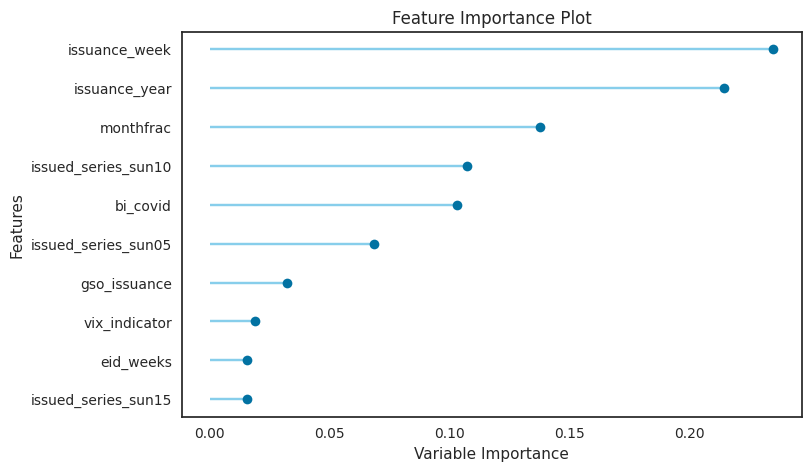

In [50]:
plot_model(et_boosted, plot = 'feature')

## Random Forest Regressor

### Raw -- 63.79%

In [51]:
# train a rf model with default params
rf_raw = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2196505.4334,10544102385559.1250,3247168.3642,0.6870,1.2066,0.5632
1,2641646.4995,15758083234840.4375,3969645.2278,0.5299,1.2796,0.6866
2,2421257.1551,11484985195047.2285,3388950.4563,0.7205,1.6414,0.6752
3,2373246.2278,14736215632283.0938,3838777.8826,0.5946,1.6860,0.7805
4,2533927.2640,11058552243370.1836,3325440.1578,0.6623,0.7996,1.3432
5,2170428.1369,8964968326279.3809,2994155.6951,0.7533,1.7229,2.2752
6,2332853.4183,11352100481017.4668,3369287.8299,0.6224,1.2579,1.5095
7,2235614.3027,10704286506748.9727,3271740.5928,0.6665,0.6001,0.6205
8,3101092.6310,26360140521560.0234,5134212.7460,0.5217,0.6881,0.8316


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 56.95%

In [52]:
# tune hyperparameters of rf
rf_tuned = tune_model(rf_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2638967.9298,14124229461864.5527,3758221.5823,0.5808,1.3579,0.7940
1,2857151.9079,18141767562356.6875,4259315.3866,0.4588,1.3522,0.8130
2,2598609.6045,12475343081093.8633,3532045.1697,0.6964,1.8088,0.9396
3,2567664.2681,15876945081521.2188,3984588.4457,0.5632,1.7749,0.9205
4,2771505.5955,13196409278106.8516,3632686.2345,0.5970,0.8378,1.4259
5,2588198.8665,12482823434594.0488,3533103.9377,0.6565,1.8397,3.0158
6,2649784.9277,14461045405902.4160,3802768.1241,0.5190,1.3774,3.1058
7,2481404.8116,12301410181822.4648,3507336.6223,0.6167,0.7205,0.9277
8,3413033.7673,29566963200316.7695,5437551.2136,0.4635,0.7582,1.0425


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Modifying -- 62.61%

In [53]:
# define a more comprehensive tuning grid for Random Forest Regressor
rf_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 4, 8, 12, 16],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Tune model with the optimized grid and optimize for Mean Squared Error (mse)
rf_modified = tune_model(rf_raw, custom_grid=rf_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2273714.0333,11679221206008.3750,3417487.5575,0.6533,1.2282,0.5878
1,2654513.5252,15985398022883.4297,3998174.3362,0.5231,1.2943,0.7154
2,2495097.7517,11627214450759.5312,3409870.1516,0.7170,1.6649,0.7345
3,2391464.0560,14949006946031.4727,3866394.5668,0.5888,1.7133,0.8079
4,2633015.5521,11655282264000.6055,3413983.3427,0.6440,0.8091,1.3852
5,2192990.1193,9357603574997.7148,3059020.0351,0.7425,1.7318,2.3956
6,2369695.2373,11677417675414.6211,3417223.6795,0.6116,1.2722,1.4166
7,2281008.2665,10992997326171.0215,3315568.9295,0.6575,0.6197,0.6603
8,3146381.8568,27104497725310.6562,5206198.0106,0.5082,0.6968,0.8521


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Bagging -- 62.45%

In [54]:
# ensemble with bagging
rf_bagged = ensemble_model(rf_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2317789.3174,11146508051520.3926,3338638.6524,0.6691,1.2599,0.6636
1,2709854.6361,15559857140782.4727,3944598.4765,0.5358,1.3218,0.7689
2,2460076.1279,11625658144424.0410,3409641.9379,0.7171,1.7419,0.7600
3,2478238.2884,15099843810833.8711,3885851.7484,0.5846,1.7402,0.8801
4,2622254.4465,11756167587066.3516,3428726.8172,0.6410,0.8215,1.4294
5,2403479.8725,10620596725077.6523,3258925.7011,0.7078,1.7695,3.2417
6,2451222.1531,12343811363804.0820,3513376.0635,0.5894,1.2972,1.8096
7,2289147.8414,10967814270497.2051,3311769.0545,0.6583,0.6417,0.7242
8,3171372.8671,25657393445346.0352,5065312.7688,0.5345,0.7216,0.9511


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 64.32%

In [55]:
# ensemble with boosting
rf_boosted = ensemble_model(rf_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2270879.8622,10312960461059.1465,3211379.8376,0.6939,1.2237,0.6444
1,2789494.0361,16136482482684.2871,4017024.0829,0.5186,1.3071,0.7478
2,2422971.0629,10784746816410.4473,3284013.8271,0.7375,1.6808,0.7369
3,2384460.5188,14666317826033.4531,3829662.8867,0.5965,1.6746,0.8278
4,2536277.1560,11354695133795.3027,3369672.8526,0.6532,0.8204,1.4837
5,2347353.0878,10190268753748.6328,3192220.0353,0.7196,1.7578,1.9983
6,2292973.5662,10765649604776.4902,3281104.9366,0.6419,1.2380,1.5020
7,2222598.3858,10298355140961.5215,3209105.0374,0.6791,0.6415,0.7182
8,3018657.0395,23663280547592.4688,4864491.8077,0.5707,0.6869,0.8558


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

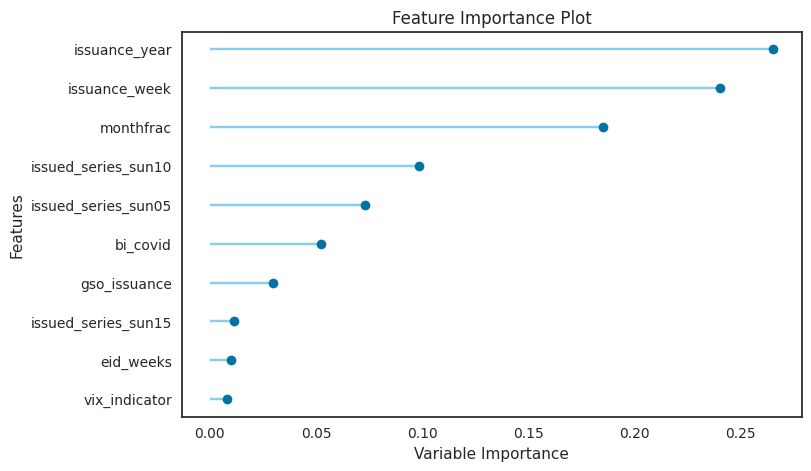

In [56]:
plot_model(rf_boosted, plot = 'feature')

# Choosen

## Blended -- 68.83%

In [57]:
# Blend the Boosted Ensembles
blended = blend_models(estimator_list=[lightgbm_modified, xgb_tuned, et_bagged, rf_boosted], fold=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2222087.3837,10104384640647.1172,3178739.4735,0.7001,1.1445,0.5740
1,2483554.6789,13297898249851.5605,3646628.3400,0.6033,1.2324,0.6130
2,2222841.5960,9890311506523.0117,3144886.5650,0.7593,1.6663,0.5849
3,2221970.8206,12790504803616.8223,3576381.5238,0.6481,1.5883,0.7470
4,2224649.9347,8645559537038.8477,2940333.2357,0.7360,0.7247,1.1159
5,2013248.9476,8137891375794.3301,2852698.9634,0.7761,1.5292,1.3511
6,2191570.9393,9845017689070.6914,3137677.1168,0.6725,1.1841,0.8108
7,2125030.7477,9568915072596.8789,3093366.3011,0.7019,0.6148,0.6149
8,2822935.6611,20843818186915.9688,4565503.0596,0.6218,0.6555,0.7938


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [58]:
predict_model(blended);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,2229338.6731,10236998007902.1582,3199530.9044,0.6689,0.5780,0.6569


In [ ]:
# plot_model(blended, plot = 'residuals')

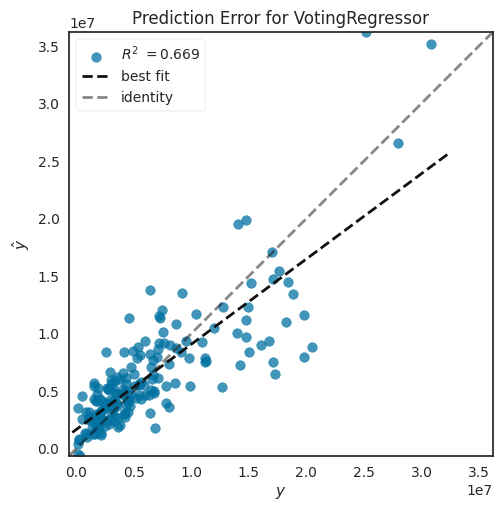

In [59]:
plot_model(blended, plot = 'error')

## Stacked -- 69.08%

In [61]:
stacked = stack_models(estimator_list=[lightgbm_modified, xgb_tuned, et_bagged, rf_boosted])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2236478.7275,10215295883645.6016,3196137.6509,0.6968,1.1261,0.5787
1,2347627.3631,12367563113309.1621,3516754.6280,0.6310,1.2500,0.5808
2,2203732.7540,9966790353091.5234,3157022.3872,0.7574,1.6657,0.5841
3,2195396.2680,12670444939036.1465,3559556.8459,0.6514,1.5915,0.7239
4,2186776.3275,8278180520128.9092,2877182.7401,0.7472,0.7055,1.0715
5,1987170.6568,8107260904501.2676,2847325.2193,0.7769,1.5371,1.1646
6,2187144.5455,9706017223589.5469,3115448.1577,0.6771,1.2029,0.8143
7,2148202.6388,9615415937126.6777,3100873.4152,0.7004,0.6075,0.6075
8,2842223.3074,21256365324595.2695,4610462.5933,0.6143,0.6495,0.7696


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [62]:
predict_model(stacked);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,2236397.9905,10182624500600.5879,3191022.4851,0.6706,0.5703,0.6344


In [ ]:
# plot_model(stacked, plot = 'residuals')

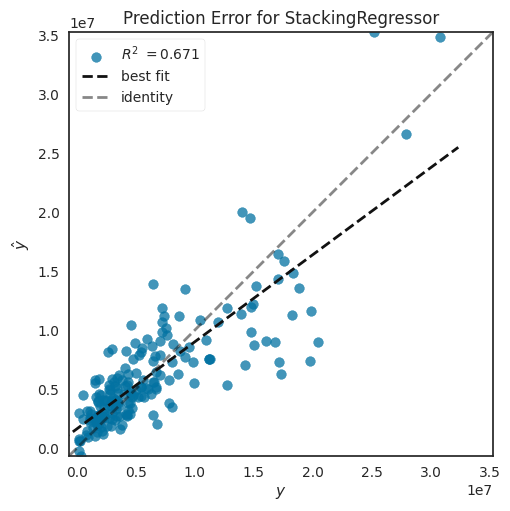

In [63]:
plot_model(stacked, plot = 'error')

## Finalizing -- 97.13%

In [64]:
final = finalize_model(stacked)
predict_model(final);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,912621.7492,1699198192634.7029,1303532.9657,0.9450,0.3285,0.2707


In [65]:
save_model(final, '/content/drive/MyDrive/00database/20240611_stacked01')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['issuance_year', 'issuance_week',
                                              'monthfrac', 'eid_weeks',
                                              'srbi_issuance', 'vix_indicator',
                                              'bi_covid', 'gso_issuance',
                                              'investment_grade'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['issued_series'],
                                     transformer=SimpleImpute...
                                                              num_parallel_tree=None,
                                                              random_state=123, ...)),
                                                ('Extra Trees Regressor',
                                                 BaggingRegress

# Lelang 11 Juni 2024

## Load

In [66]:
lelang20240611 = pd.read_excel('/content/drive/MyDrive/00database/db_monthfrac.xlsx', sheet_name='lelang20240611')
lelang20240611['issuance_date'] = pd.to_datetime(lelang20240611['issuance_date'], format='%Y-%m-%d')
lelang20240611.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   issued_series     7 non-null      object        
 1   issuance_date     7 non-null      datetime64[ns]
 2   issuance_year     7 non-null      int64         
 3   issuance_week     7 non-null      int64         
 4   monthfrac         7 non-null      int64         
 5   eid_weeks         7 non-null      int64         
 6   srbi_issuance     7 non-null      int64         
 7   vix_indicator     7 non-null      int64         
 8   bi_covid          7 non-null      int64         
 9   gso_issuance      7 non-null      int64         
 10  investment_grade  7 non-null      int64         
dtypes: datetime64[ns](1), int64(9), object(1)
memory usage: 744.0+ bytes


## Predict

In [67]:
# load model
stacked01_20240611 = load_model("/content/drive/MyDrive/00database/20240611_stacked01")

# predict model on new_data
predict03= predict_model(stacked01_20240611, data = lelang20240611)
predict03

# predict model on new_data
# predict03= predict_model(final, data = lelang20240611)
# predict03

Transformation Pipeline and Model Successfully Loaded


,issued_series,issuance_date,issuance_year,issuance_week,monthfrac,eid_weeks,srbi_issuance,vix_indicator,bi_covid,gso_issuance,investment_grade,prediction_label
0,spn03,2024-06-11,2024,24,3,0,1,0,0,0,1,3.036071e+06
1,spn12,2024-06-11,2024,24,12,0,1,0,0,0,1,4.900766e+06
2,sun05,2024-06-11,2024,24,58,0,1,0,0,0,1,1.366787e+07
3,sun10,2024-06-11,2024,24,116,0,1,0,0,0,1,1.847286e+07
4,sun15,2024-06-11,2024,24,168,0,1,0,0,0,1,8.197984e+06
5,sun20,2024-06-11,2024,24,228,0,1,0,0,0,1,7.025139e+06
6,sun30,2024-06-11,2024,24,361,0,1,0,0,0,1,4.513385e+06


In [68]:
# @title Lelang 20240611: Per series

# !pip install --upgrade pip
# !pip install tabulate

import tabulate

# Incoming bid per series
predict04 = predict03[['issued_series', 'issuance_date', 'prediction_label']]

# Create a new column with formatted dates
predict04['issuance_date'] = predict04['issuance_date'].dt.strftime('%Y-%m-%d')

# Format the 'prediction_label' column
predict04['prediction_label'] = predict04['prediction_label'].apply(lambda x: '{:,.2f} trillion'.format(x / 1_000_000))

# Convert the DataFrame to a list of dictionaries for tabulate
table_data = predict04.to_dict(orient='records')

# Specify the column alignments
column_alignments = {'issued_series': 'left', 'issuance_date': 'center', 'prediction_label': 'right'}

# Display the formatted DataFrame using tabulate
formatted_table = tabulate.tabulate(table_data, headers="keys", floatfmt=".2f", showindex=False, colalign=list(column_alignments.values()), tablefmt="pipe")

print(formatted_table)

| issued_series   |  issuance_date  |   prediction_label |
|:----------------|:---------------:|-------------------:|
| spn03           |   2024-06-11    |      3.04 trillion |
| spn12           |   2024-06-11    |      4.90 trillion |
| sun05           |   2024-06-11    |     13.67 trillion |
| sun10           |   2024-06-11    |     18.47 trillion |
| sun15           |   2024-06-11    |      8.20 trillion |
| sun20           |   2024-06-11    |      7.03 trillion |
| sun30           |   2024-06-11    |      4.51 trillion |


In [69]:
# @title Lelang 20240611: Total

# Sum total incoming bid
incoming_bid = predict03['prediction_label'].sum()

# Round to two decimal places
rounded_bid = round(incoming_bid, 2)
formatted_rounded_bid = 'Rp{:,.2f} million'.format(rounded_bid)

# Adjust to the nearest thousand
formatted_incoming_bid = 'Rp{:,.2f} trillion'.format(rounded_bid / 1000000)

output_message = f"""
According to a stacked machine learning algorithm model with an R-squared value of 69.08%,
the estimated incoming bid for the next issuance is approximately {formatted_rounded_bid}
or {formatted_incoming_bid}.
"""

print(output_message)



According to a stacked machine learning algorithm model with an R-squared value of 69.08%,
the estimated incoming bid for the next issuance is approximately Rp59,814,079.00 million
or Rp59.81 trillion.

